In [1]:
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import csv
import cv2

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, MaxPool3D, ConvLSTM2D, Flatten, Reshape, Dense, Activation, Dropout, SimpleRNN, LSTM, GRU
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split

In [2]:
path = '../input/nnfl-2021-assignment-2/'
target_size = (128,128)
seq_len = 45

def frames_extraction(video_path):
    frames_list = []
    vidObj = cv2.VideoCapture(video_path)
    while True:
        success, frame = vidObj.read()
        if not success:
            break
        frames_list.append((cv2.resize(frame, target_size))/255)
    while len(frames_list) < seq_len:
        frames_list.append(frames_list[-1])
    frames_list = frames_list[::(len(frames_list))//seq_len]
    return frames_list[:seq_len]

In [3]:
ip_train_val = pd.read_csv('../input/nnfl-2021-assignment-2/train.csv', header=0).values

x_train_val = []
y_train_val = []

for vid in ip_train_val:
    x_train_val.append(frames_extraction(path+'/train/'+vid[0]))
    y_train_val.append(int(vid[1]=="fire")) # fire: 1, non-fire: 0

[NULL @ 0x557dd2800840] Header truncated
[mpeg4 @ 0x557dd27feb80] Header truncated
[mpeg4 @ 0x557dd27feb80] header damaged


In [4]:
x_train, x_valid, y_train, y_valid = train_test_split(x_train_val, y_train_val, test_size=0.20, random_state=0)
x_train = np.array(x_train)
x_valid = np.array(x_valid)
y_train = np.array(y_train)
y_valid = np.array(y_valid)

In [53]:
earlystop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=4, verbose=0, mode='auto')
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=2, verbose=1, factor=0.3, min_lr=0.0001)
callbacks = [learning_rate_reduction, earlystop]

In [6]:
# # ConvLSTM Model:

# inp = Input(x_train[0].shape)
# # ConvLSTM
# convOut = ConvLSTM2D(filters = 16, kernel_size = (3, 3), return_sequences = False, data_format = "channels_last")(inp)

# # flatten
# flatOut = Flatten()(convOut)

# # dense layers
# denseOut = Dense(64, activation=tf.nn.relu, kernel_regularizer=tf.keras.regularizers.L2(0.01))(flatOut)
# denseOut = Dropout(0.1)(denseOut)
# out = Dense(1, activation="sigmoid")(denseOut)
 
# model = Model(inputs = inp, outputs = out)
# model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001), loss = 'binary_crossentropy', metrics = ['accuracy']) ## metrics
# print(model.summary())

In [82]:
inp = Input(x_train[0].shape)
# conv layers
convOut = Conv2D(16, (3, 3), padding='valid', activation='relu', data_format="channels_last")(inp)
convOut = MaxPool3D((1, 2, 2))(convOut)
convOut = Conv2D(8, (3, 3), padding='valid', activation='relu', data_format="channels_last")(convOut)
convOut = MaxPool3D((1, 2, 2))(convOut)

# flatten
flatOut = Reshape((seq_len, -1))(convOut)

# RNN
rnnOut = LSTM(512, return_sequences = False)(flatOut)

# dense layers
denseOut = Dense(256, activation='tanh', kernel_regularizer=tf.keras.regularizers.L2(0.01))(rnnOut)
denseOut = Dropout(0.2)(denseOut)
denseOut = Dense(32, activation='tanh', kernel_regularizer=tf.keras.regularizers.L2(0.01))(denseOut)
out = Dense(1, activation='sigmoid')(denseOut)

model = Model(inputs = inp, outputs = out)
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001), loss = 'binary_crossentropy', metrics = ['accuracy'])
print(model.summary())

Model: "model_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_20 (InputLayer)        [(None, 45, 128, 128, 3)] 0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 45, 126, 126, 16)  448       
_________________________________________________________________
max_pooling3d_30 (MaxPooling (None, 45, 63, 63, 16)    0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 45, 61, 61, 8)     1160      
_________________________________________________________________
max_pooling3d_31 (MaxPooling (None, 45, 30, 30, 8)     0         
_________________________________________________________________
reshape_19 (Reshape)         (None, 45, 7200)          0         
_________________________________________________________________
lstm_19 (LSTM)               (None, 512)               157

In [83]:
history = model.fit(x_train, y_train, validation_data=(x_valid, y_valid), epochs=20, batch_size=4, callbacks=callbacks)

Epoch 1/20
24/24 [==============================] - 4s 92ms/step - loss: 4.2084 - accuracy: 0.5208 - val_loss: 3.3903 - val_accuracy: 0.5833
Epoch 2/20
24/24 [==============================] - 1s 55ms/step - loss: 2.9589 - accuracy: 0.4479 - val_loss: 2.5135 - val_accuracy: 0.5417
Epoch 3/20
24/24 [==============================] - 1s 55ms/step - loss: 2.2421 - accuracy: 0.5000 - val_loss: 1.9660 - val_accuracy: 0.5417

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
Epoch 4/20
24/24 [==============================] - 1s 55ms/step - loss: 1.8837 - accuracy: 0.6146 - val_loss: 1.8080 - val_accuracy: 0.6250
Epoch 5/20
24/24 [==============================] - 1s 60ms/step - loss: 1.7097 - accuracy: 0.7292 - val_loss: 1.6342 - val_accuracy: 0.7500
Epoch 6/20
24/24 [==============================] - 2s 68ms/step - loss: 1.5907 - accuracy: 0.7083 - val_loss: 1.5300 - val_accuracy: 0.7083
Epoch 7/20
24/24 [==============================] - 1s 61ms/step - loss: 

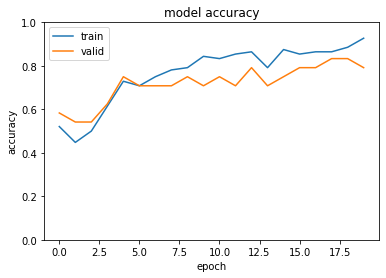

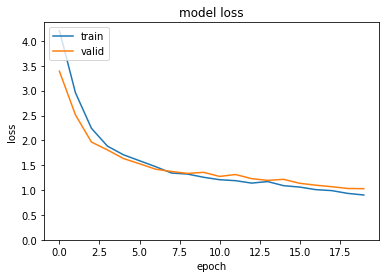

In [84]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.ylim(bottom=0, top=1)
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.ylim(bottom=0)
plt.show()

In [85]:
ip_test = pd.read_csv('../input/nnfl-2021-assignment-2/test.csv', header=0).values
ans = 0
with open('sample_output_actual.csv', 'w') as file:
    writer = csv.writer(file)
    writer.writerow(['File', 'Label'])
    cnt = 0
    for vid in ip_test:
        test_vid = np.array(frames_extraction(path+'/test/'+vid[0]))
        test_vid = test_vid.reshape(-1,seq_len,128,128,3)
        prediction = model.predict(test_vid)
        st = 'fire'
        if (prediction[0] < 0.5):
            st = 'not_fire'
            if vid[0][0]=='2':
                ans += 1
        else:
            if vid[0][0]=='1':
                ans += 1
        print(ip_test[cnt][0], st)
        writer.writerow([ip_test[cnt][0], st])
        cnt += 1
print(ans*5)

2_7.avi not_fire
2_65.avi not_fire
1_65.avi fire
1_69.avi fire
1_9.avi fire
2_64.avi not_fire
1_7.avi fire
1_8.avi fire
2_8.avi fire
2_9.avi not_fire
1_68.avi not_fire
2_70.avi fire
2_66.avi fire
2_69.avi fire
1_66.avi fire
2_68.avi fire
1_64.avi fire
2_67.avi not_fire
1_70.avi fire
1_67.avi fire
70
